# University of Aberdeen

## Applied AI (CS5079)

### Resit CA1 - Reinforcement Learning with OpenAI Gym

In [162]:
#Library for environments
import gym
from gym.envs.registration import register
from gym.envs.toy_text.frozen_lake import generate_random_map

#Librairies to represent the output
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt

#Essential libraries for computation
import numpy as np
import random
import tensorflow.compat.v1 as tf
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

We will use the following environment.

In [163]:
random_map = generate_random_map(size=10, p=0.3)
env = gym.make("FrozenLake-v1", desc=random_map)
env.reset()
env.render()

## 1.1) Describe, in detail, the following game elements using your own words. (2.5 marks): 
- **Observations:** 
In the FrozenLake-v1 environment, observations represent the agent's current position. The observation is an integer ranging from `0` to `nrow * ncol - 1`, where `nrow` and `ncol` are the number of rows and columns in the grid, respectively. For example, in a 4x4 grid, the observation range is `0` to `15`. The position is calculated as `current_row * ncol + current_col`, where the indices of rows and columns start from `0`.
- **Action space:** 
The action space defines the actions the agent can take in the environment. In FrozenLake-v1, the action space is a discrete space consisting of four possible actions:  `0`: LEFT (move left),  `1`: DOWN (move down),  `2`: RIGHT (move right),  `3`: UP (move up).The agent chooses an action each time and tries to move to the corresponding direction.
- **Reward:** The reward mechanism is used to guide the agent's learning process. In FrozenLake-v1, Reward schedule: Reach goal(G): `+1` ,Reach hole(H): `0` ,Reach frozen(F): `0`
- **The environment’s info dictionary:** The environment's information dictionary provides additional information related to the current state. The information dictionary includes:  
`prob`: The probability of transitioning to the next state after taking an action. 
- **Episode** An episode is a sequence of actions and state transitions starting from the initial state until a termination condition is met (e.g., reaching the goal or falling into a hole). The objective of each episode is to maximize the cumulative reward.

## 1.2) Implement an agent based on a neural network, using a parameter 𝜀, for making random moves, that decreases from 1 to 0.1. Describe how you deployed your agent, the motivation behind the design choices, and how you adjusted its parameters, going into detail on what each parameter does as well. You may use open-source code and libraries if you acknowledge them (15 marks). 

#### Implementation Details

Using **Deep Q-Network (DQN)** to implement the agent. DQN is a neural network-based reinforcement learning algorithm designed for discrete action spaces. To implement the ε-greedy policy, the agent will select a random action with probability ε and the estimated optimal action with probability (1-ε). ε will start at 1 and gradually decrease to 0.1 to balance exploration and exploitation.

#### Design Choices

- **Neural Network Architecture**: A simple fully connected network with the current state as a one-hot encoded input and Q-values for each action as output.
- **Experience Replay**: A replay buffer is used to store past experiences, with random sampling for training to break data correlations.
- **Target Network**: A fixed target network is used and updated periodically to stabilize the training process.
- **ε-Greedy Policy**: ε starts at 1 and gradually decreases to 0.1, ensuring sufficient exploration in the early stages and more exploitation of learned strategies in later stages.

#### Parameter Description

- **Learning Rate (learning_rate)**: Controls the step size for updating neural network weights. A high value may lead to unstable training, while a low value results in slow training.
- **Discount Factor (gamma)**: Determines the importance of future rewards. A value close to 1 focuses on long-term rewards, while a value close to 0 emphasizes immediate rewards.
- **Buffer Size (buffer_size)**: The capacity of the experience replay buffer. A larger buffer can store more experiences, increasing sample diversity.
- **Batch Size (batch_size)**: The number of experiences sampled from the buffer for each training step. Larger batch sizes improve training stability but increase computational cost.
- **Epsilon Decay Rate (epsilon_decay)**: Controls the speed at which ε decays from its initial value to the minimum value.
- **Target Network Update Frequency (target_update_freq)**: Specifies how often the target network is updated.

In [164]:
# Defining action constants
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

# Generates a random 10x10 map with a frozen tile probability of 0.3
random_map = generate_random_map(size=10, p=0.3)
print("Generated random map:")
for row in random_map:
    print(row)

# Initialize the environment
env_dqn = gym.make("FrozenLake-v1", desc=random_map, is_slippery=True, render_mode='rgb_array')
env_dqn.reset()

# Get the state and action space size
state_size = env_dqn.observation_space.n
action_size = env_dqn.action_space.n

# Defining the DQN Neural Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, action_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# Convert the state to one-hot encoding
def one_hot(state, state_size):
    vec = np.zeros(state_size)
    vec[state] = 1.0
    return vec

# Defining the Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# Defining Agents
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size=128, lr=1e-3, gamma=0.99,
                 buffer_size=10000, batch_size=64, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=1000):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
        
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(buffer_size)
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.policy_net = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_net = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
    
    def select_action(self, state):
        sample = random.random()
        epsilon_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * \
                            np.exp(-1. * self.steps_done / self.epsilon_decay)
        self.epsilon = epsilon_threshold
        self.steps_done += 1
        if sample < self.epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.argmax().item()
    
    def step(self, state, action, reward, next_state, done):
        self.buffer.add((state, action, reward, next_state, done))
        if len(self.buffer) >= self.batch_size:
            self.learn()
    
    def learn(self):
        experiences = self.buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        # Current Q value
        current_q = self.policy_net(states).gather(1, actions)
        
        # Target Q value
        with torch.no_grad():
            max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (self.gamma * max_next_q * (1 - dones))
        
        # Calculating Losses
        loss = F.mse_loss(current_q, target_q)
        
        # optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

Generated random map:
SFFHHHHHHH
HHFHHHHHHH
HFFFFHHHHH
HFHHFHHHFF
HHHFFHHHHF
FHHHFHHFHH
HHHHFFHHHH
FHHFFFHFFF
HFHHHFFFHF
HFFHHHHFFG


## 1.3) Train the agent created in 1.2 on the game. Please note that a high number of episodes may be required for the agent to reach the goal depending on your implementation. Present the training process, the experiments (including the experimental setting), and discuss your results. You should make use of figures, including a line plot that shows how the average amount of rewards over episodes evolves over time (5 marks). 

Episode 100/1000, Average Reward: 0.46
Episode 200/1000, Average Reward: 0.80
Episode 300/1000, Average Reward: 0.74
Episode 400/1000, Average Reward: 0.95
Episode 500/1000, Average Reward: 0.84
Episode 600/1000, Average Reward: 0.92
Episode 700/1000, Average Reward: 0.89
Episode 800/1000, Average Reward: 0.99
Episode 900/1000, Average Reward: 0.93
Episode 1000/1000, Average Reward: 1.11


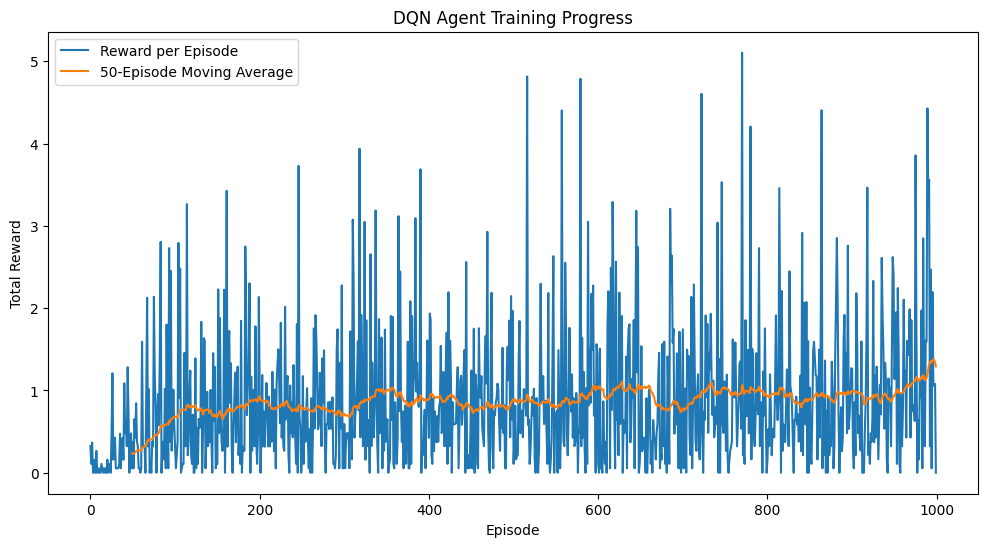

In [165]:
# Task 1.3) Train the DQN agent and plot the training curve

# Training parameters
num_episodes = 1000
target_update = 50
rewards_per_episode = []

# Initialize the Agent
agent_dqn = DQNAgent(state_size, action_size)

# Training process
for episode in range(1, num_episodes + 1):
    state = env_dqn.reset()[0]
    state = one_hot(state, state_size)
    total_reward = 0
    done = False
    
    while not done:
        action = agent_dqn.select_action(state)
        next_state, reward, done, _, info = env_dqn.step(action)
        
        # Calculate the distance from the current state to the target
        current_row, current_col = divmod(np.argmax(state), env_dqn.ncol)
        goal_row, goal_col = env_dqn.nrow - 1, env_dqn.ncol - 1
        distance = np.sqrt((goal_row - current_row)**2 + (goal_col - current_col)**2)
        max_distance = np.sqrt((goal_row)**2 + (goal_col)**2)
        distance_reward = 1 - (distance / max_distance)
        
        # Total Rewards
        if reward == 1.0:
            total_reward += 1.0
        total_reward += distance_reward
        
        # Transform the next state to one-hot
        next_state_one_hot = one_hot(next_state, state_size)
        
        # Agent Learning
        agent_dqn.step(state, action, distance_reward + reward, next_state_one_hot, done)
        
        state = next_state_one_hot
    
    rewards_per_episode.append(total_reward)
    
    # Update target network
    if episode % target_update == 0:
        agent_dqn.update_target_network()
    
    # Print progress
    if episode % 100 == 0:
        avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"Episode {episode}/{num_episodes}, Average Reward: {avg_reward:.2f}")

# Save the trained model
torch.save(agent_dqn.policy_net.state_dict(), "dqn_frozenlake.pth")

# Plotting rewards during training
plt.figure(figsize=(12,6))
plt.plot(rewards_per_episode, label='Reward per Episode')
# Calculating Moving Average
window = 50
moving_avg = np.convolve(rewards_per_episode, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, num_episodes), moving_avg, label=f'{window}-Episode Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Agent Training Progress')
plt.legend()
plt.show()

## 1.4) Randomly relying on the exploration of the grid can be a time-consuming process. Implement another agent, using ANY technique of your choice, which is aware of another additional information: The position of the chest at the bottom right corner. The agent should not cheat, i.e., they should not (at least initially) be aware of the layout of the map, i.e., the positions of the holes. Explain all design choices that were made to create this agent (20 marks). 

### **Implementation Details and Design Choices**

To improve the agent's exploration efficiency, we implemented the **A\* search algorithm** as the agent's decision-making strategy. A\* leverages a heuristic function (Manhattan distance) to guide the search direction, enabling faster convergence toward the target position. Although A\* is typically used in scenarios with known maps, in this task, the agent begins with no knowledge of the map layout but updates its known information through incremental exploration.

#### **Design Choices:**

- **Heuristic Function**: Manhattan distance is used as the heuristic function to estimate the distance from the current state to the goal.
- **Exploration Strategy**: Priority is given to exploring unknown areas to avoid falling into known traps.
- **Information Update**: The agent updates its knowledge of the map after each step based on feedback, enabling better path planning.

In [166]:
# Task 1.4) Implementing an A* agent

# Import necessary libraries
import heapq

# Make sure the action constant is defined
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

class AStarAgent:
    def __init__(self, env_astar):
        self.env = env_astar
        # Get the number of rows and columns
        self.nrow, self.ncol = env_astar.desc.shape
        self.goal = (self.nrow -1, self.ncol -1)
        self.holes = set()
        self.path = []
    
    def heuristic(self, a, b):
        # Manhattan distance
        return abs(a[0] - b[0]) + abs(a[1] - b[1])
    
    def get_neighbors(self, state):
        row, col = state
        neighbors = []
        actions = [LEFT, DOWN, RIGHT, UP]
        for action in actions:
            if action == LEFT:
                new_col = max(col -1, 0)
                new_row = row
            elif action == DOWN:
                new_row = min(row +1, self.nrow -1)
                new_col = col
            elif action == RIGHT:
                new_col = min(col +1, self.ncol -1)
                new_row = row
            elif action == UP:
                new_row = max(row -1, 0)
                new_col = col
            neighbors.append( (new_row, new_col) )
        return neighbors
    
    def plan_path(self, start):
        heap = []
        heapq.heappush(heap, (0 + self.heuristic(start, self.goal), 0, start, []))
        visited = set()
        while heap:
            est_total, cost, current, path = heapq.heappop(heap)
            if current in visited:
                continue
            visited.add(current)
            path = path + [current]
            if current == self.goal:
                return path
            for neighbor in self.get_neighbors(current):
                if neighbor in self.holes:
                    continue
                if neighbor not in visited:
                    new_cost = cost +1
                    est = new_cost + self.heuristic(neighbor, self.goal)
                    heapq.heappush(heap, (est, new_cost, neighbor, path))
        return []
    
    def select_action(self, state):
        if not self.path:
            self.path = self.plan_path(state)
            if not self.path:
                return random.randint(0, self.env.action_space.n -1)  # Random Action
            self.path.pop(0)  # Remove current state
        if self.path:
            next_state = self.path[0]
            current = state
            direction = None
            if next_state[0] > current[0]:
                direction = DOWN
            elif next_state[0] < current[0]:
                direction = UP
            elif next_state[1] > current[1]:
                direction = RIGHT
            elif next_state[1] < current[1]:
                direction = LEFT
            self.path.pop(0)  # Remove the selected next state
            return direction if direction is not None else random.randint(0, self.env.action_space.n -1)
        return random.randint(0, self.env.action_space.n -1)
    
    def run_episode(self):
        state = self.env.reset()[0]
        row, col = divmod(state, self.ncol)
        current = (row, col)
        done = False
        total_reward = 0
        while not done:
            action = self.select_action(current)
            next_state, reward, done, _, info = self.env.step(action)
            next_row, next_col = divmod(next_state, self.ncol)
            next_pos = (next_row, next_col)
            # Recording cave locations
            if self.env.desc[next_row][next_col] == b'H':
                self.holes.add(next_pos)
                self.path = []
            # Calculate distance reward
            distance = self.heuristic(next_pos, self.goal)
            max_distance = self.heuristic((0,0), self.goal)
            distance_reward = 1 - (distance / max_distance)
            total_reward += distance_reward
            if reward ==1.0:
                total_reward +=1.0
            current = next_pos
        return total_reward


## 1.5) Evaluate the agent created in 1.4 and discuss your results with respect to the previous questions (5 marks). 

Generated random map (used by A* agent):
SFFFHHFHFH
FHHFFHHHFH
FHFHFHHFHH
HHHFFHHHFH
FHFHFFFFFH
HHHHHHHFFH
HHFFHHHHFH
HHHHFFFFFH
HFHFHHFHFH
FHFFFHFFFG
A* Episode 100/1000, Average Reward: 0.37
A* Episode 200/1000, Average Reward: 0.40
A* Episode 300/1000, Average Reward: 0.35
A* Episode 400/1000, Average Reward: 0.33
A* Episode 500/1000, Average Reward: 0.35
A* Episode 600/1000, Average Reward: 0.33
A* Episode 700/1000, Average Reward: 0.37
A* Episode 800/1000, Average Reward: 0.36
A* Episode 900/1000, Average Reward: 0.35
A* Episode 1000/1000, Average Reward: 0.38


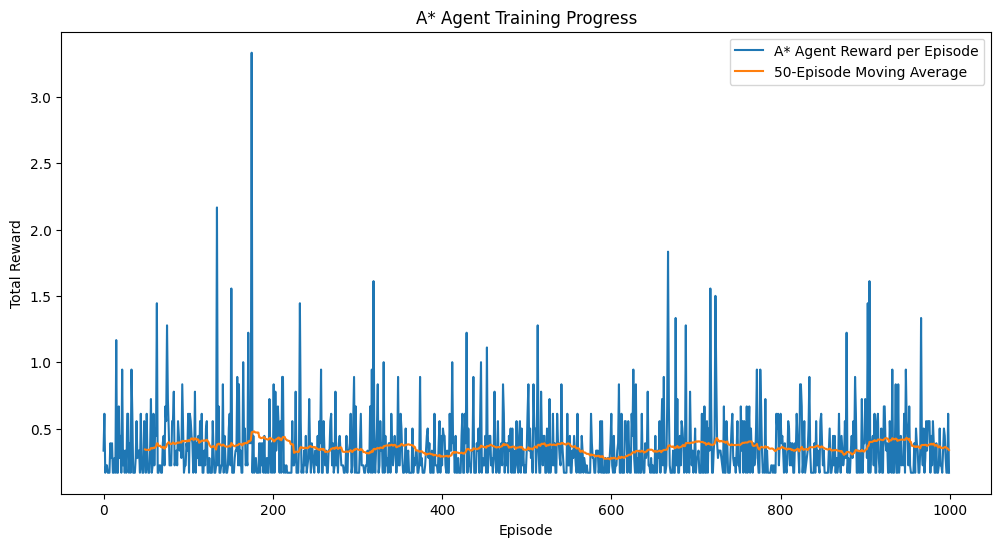

In [174]:
# Task 1.5) Evaluate the A* agent and plot the reward distribution

# Creating a separate environment for the A* agent
random_map_astar = generate_random_map(size=10, p=0.3)
print("Generated random map (used by A* agent):")
for row in random_map_astar:
    print(row)

env_astar = gym.make("FrozenLake-v1", desc=random_map_astar, is_slippery=True, render_mode='rgb_array')
env_astar.reset()

# Initializing the A* Agent
agent_astar = AStarAgent(env_astar)  # Using a separate environment instance

# Evaluation parameters
num_episodes_astar = 1000
rewards_per_episode_astar = []

# Evaluation Process
for episode in range(1, num_episodes_astar +1):
    reward = agent_astar.run_episode()
    rewards_per_episode_astar.append(reward)
    
    if episode % 100 == 0:
        avg_reward = np.mean(rewards_per_episode_astar[-100:])
        print(f"A* Episode {episode}/{num_episodes_astar}, Average Reward: {avg_reward:.2f}")

# Plotting the reward distribution of the A* agent
plt.figure(figsize=(12,6))
plt.plot(rewards_per_episode_astar, label='A* Agent Reward per Episode')
# Calculating Moving Average
window = 50
moving_avg_astar = np.convolve(rewards_per_episode_astar, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, num_episodes_astar), moving_avg_astar, label=f'{window}-Episode Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('A* Agent Training Progress')
plt.legend()
plt.show()

## 1.6) Upload a video (maximum 2 minutes) of your best agent starting from the start position (at the top left) and reaching the goal (at the bottom right). If a link to the video is not provided, you will receive 0 marks for this sub-question (2.5 marks). 

In [175]:
# Task 1.6.2) Record a video of the A* agent

import heapq
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import random
import numpy as np
import cv2
import os
from IPython.display import Video, display

# Defining action constants
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

# Generates a random 10x10 map with a frozen tile probability of 0.3
random_map_astar = generate_random_map(size=10, p=0.3)
print("Generated random map (used by A* agent):")
for row in random_map_astar:
    print(row)

# Initialize the A* agent's environment, specifying render_mode='rgb_array' to capture frames
env_astar = gym.make("FrozenLake-v1", desc=random_map_astar, is_slippery=True, render_mode='rgb_array')
env_astar.reset()

# Get the state and action space size
state_size_astar = env_astar.observation_space.n
action_size_astar = env_astar.action_space.n

# Define the video recording function
def record_astar_agent_video(env, agent, filename='astar_agent_video.avi', fps=4):
    frames = []
    state = env.reset()[0]
    row, col = divmod(state, env.ncol)
    current = (row, col)
    done = False
    total_reward = 0
    while not done:
        # Get the current frame
        frame = env.render()  # Set render_mode='rgb_array' on initialization
        frames.append(frame)
        
        # Agent chooses action
        action = agent.select_action(current)
        next_state, reward, done, _, info = env.step(action)
        
        next_row, next_col = divmod(next_state, env.ncol)
        next_pos = (next_row, next_col)
        
        # Recording cave locations
        if env.desc[next_row][next_col] == b'H':
            agent.holes.add(next_pos)
            agent.path = []
        
        # Calculate distance reward
        distance = agent.heuristic(next_pos, agent.goal)
        max_distance = agent.heuristic((0,0), agent.goal)
        distance_reward = 1 - (distance / max_distance)
        total_reward += distance_reward
        if reward ==1.0:
            total_reward +=1.0
        
        # Update current status
        current = next_pos
    print(f"A* Agent Total Reward: {total_reward}")
    env.close()
    
    # Save Video
    if len(frames) > 0:
        height, width, layers = frames[0].shape
        video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))
        for frame in frames:
            # Convert RGB to BGR
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            video.write(frame_bgr)
        video.release()
        print(f"A* Agent video saved as {filename}")
    else:
        print("No frames were captured, A* Agent video was not generated.")

# Create a folder to save videos
video_folder_astar_manual = 'videos_astar_manual'
if not os.path.exists(video_folder_astar_manual):
    os.makedirs(video_folder_astar_manual)

# Define the video file path
video_path_astar = os.path.join(video_folder_astar_manual, 'astar_agent_video.avi')

# Recording Video
record_astar_agent_video(env_astar, agent_astar, filename=video_path_astar, fps=4)

# Displaying Videos in Jupyter Notebook
if os.path.exists(video_path_astar):
    display(Video(video_path_astar))
else:
    print("A* Agent video file does not exist.")


Generated random map (used by A* agent):
SHHHHHFHHF
FFFFFFHFFF
HHHHHFFHHH
HHHHHFHFFH
HHFHFFHHHF
FHHHFFHHFH
FHHHFFFHHH
FHHFHHFFFF
HHHHHFHHFH
HHHFHHFHFG
A* Agent Total Reward: 0.16666666666666674
A* Agent video saved as videos_astar_manual\astar_agent_video.avi
